In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold



### Anomaly Detection Using Gaussian Distribution
Contents of our data:

In [2]:
train_df = pd.read_csv('D:\\Machine learning\\Datasets\\creditcard\\creditcard.csv')
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Let's visualise our data:

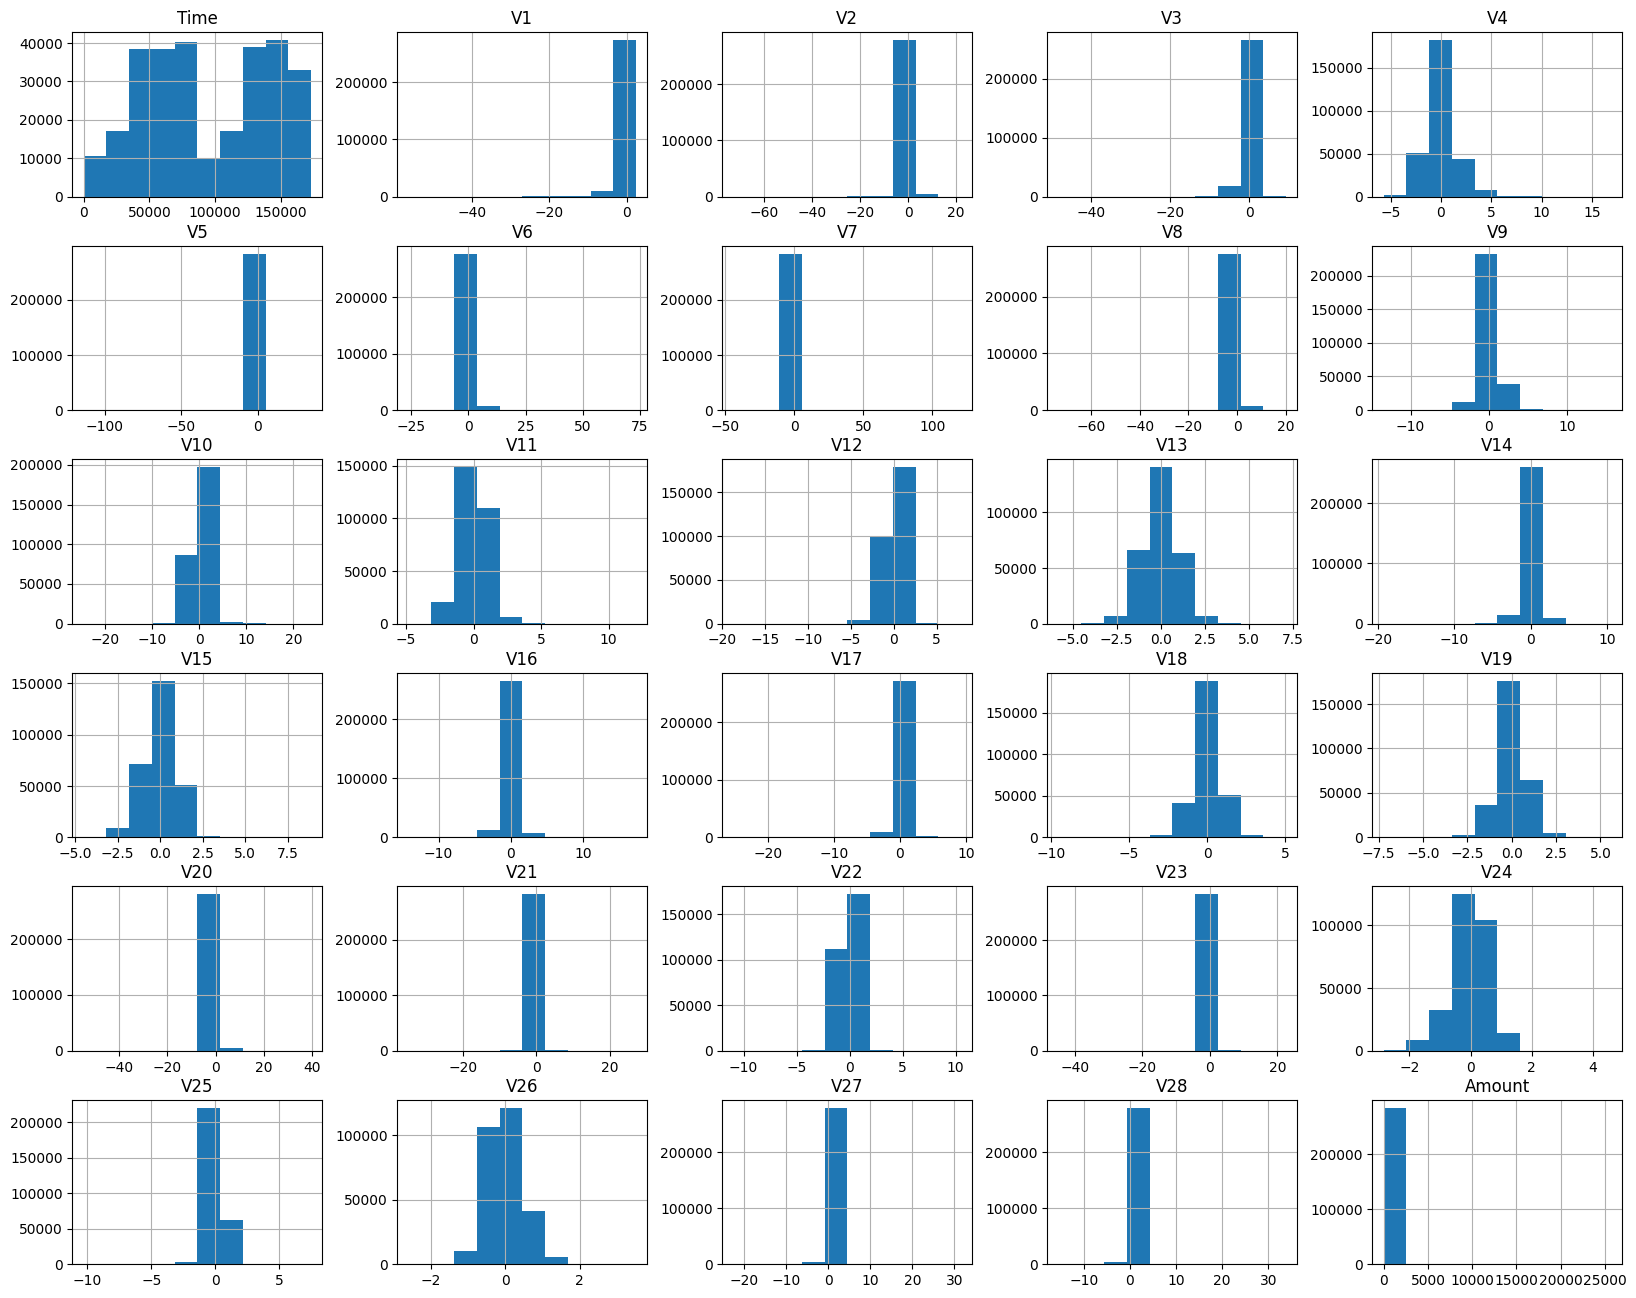

In [3]:
histogram = train_df.iloc[:,:-1]
histogram.hist(figsize=(20,16),bins=10)
plt.show()

**As you can see most of our features follow a Gaussian Distribution.**

#### Let's look at how many fraudulent transactions we have in this data:

In [25]:
g = train_df['Class'].value_counts().get(0,0)
y = train_df['Class'].value_counts().get(1,0)
print(f"Negative examples: {g}", f":Positive examples: {y}")
print(f"Ratio of positive/negative: {y/g}")#Index of 1 denotes a fraudulent transaction

Negative examples: 284315 Positive examples: 492
Ratio of positive/negative: 0.0017304750013189597


#### Here fraudulent transactions contribute to 0.17% of our entire data. Given this skewed dataset, evaluating based on the accuracy metric would not be appropriate. This is because it treats all features equally regardless of their proportionality to the dataset. 
#### For example, say 95% of the data belongs to feature A and 5% to feature B, a model that always predicts feature A would have a 95% accuracy despite performing badly on feature B.

#### Additionally, I will also be plotting a correlation heatmap, to see which features are correlated with each other. This gives us an intuition on what features are important and how they impact the predicted class. 


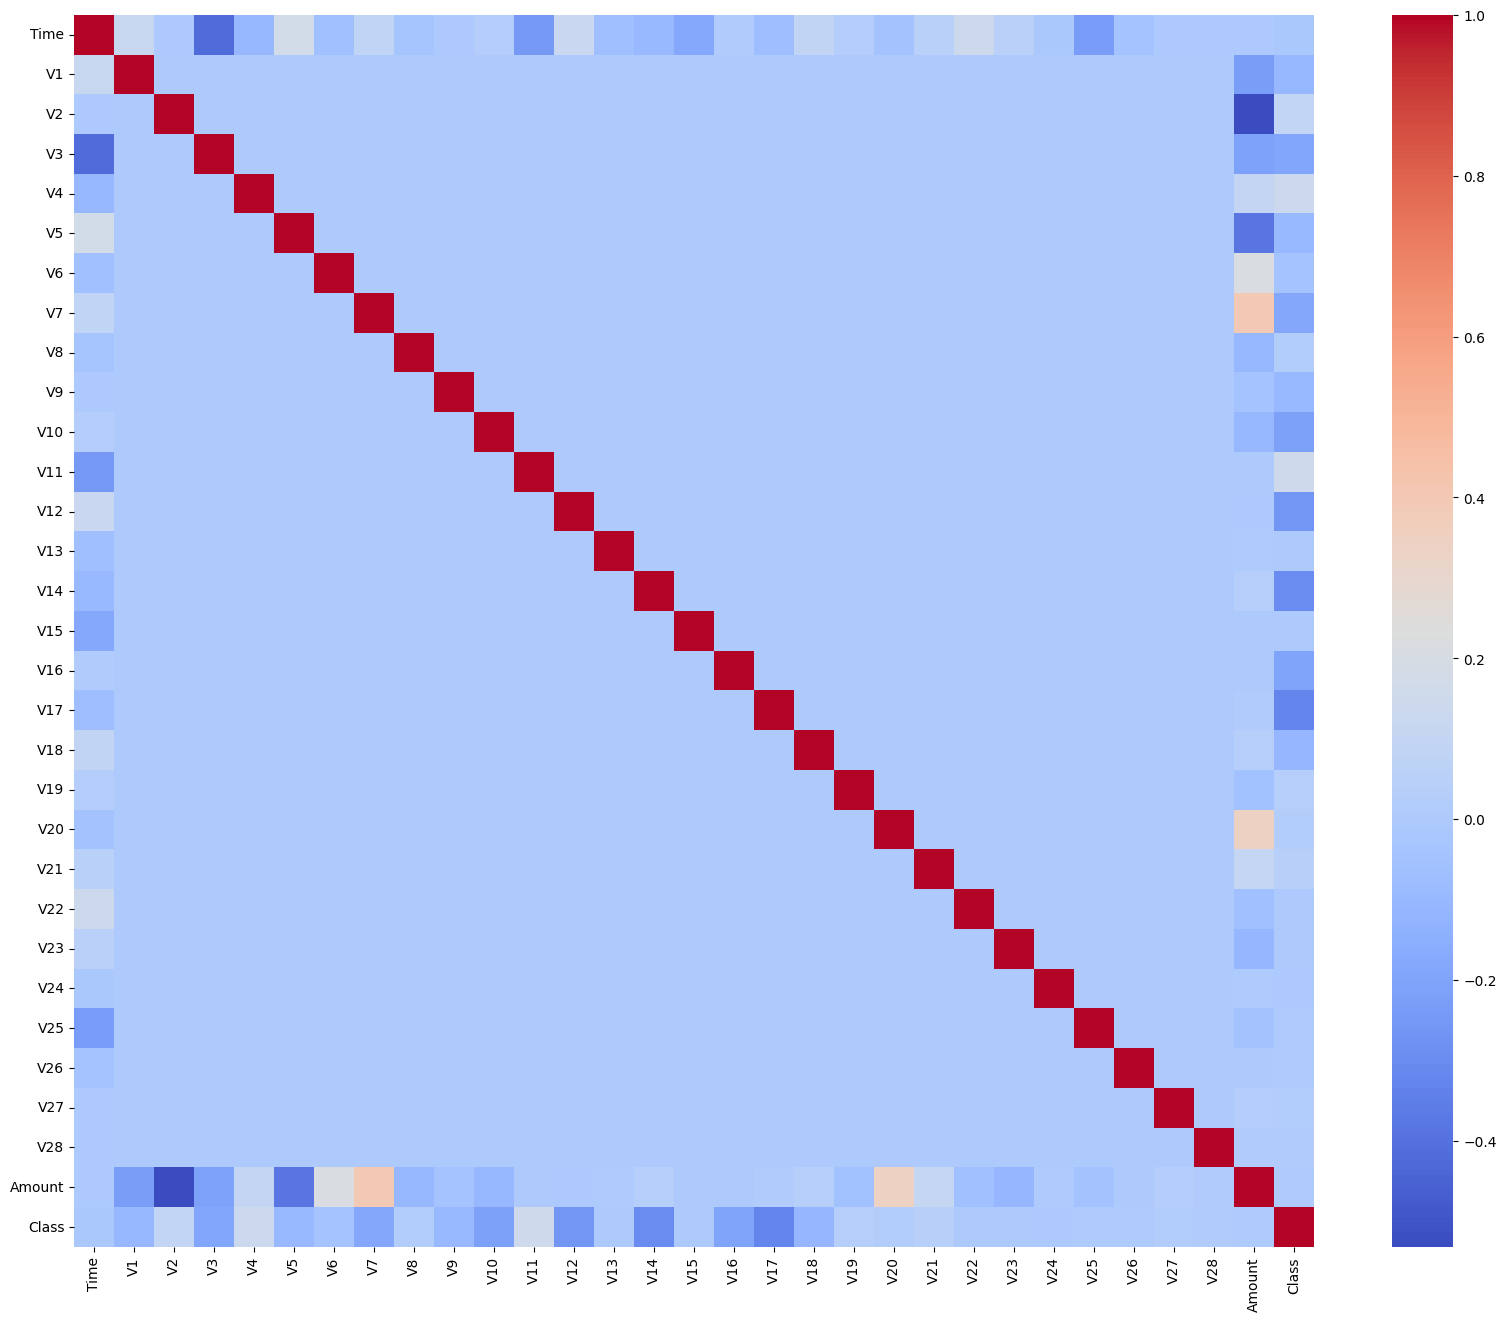

In [ ]:
corr_mtx = train_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(corr_mtx,annot=False, cmap= 'coolwarm')
plt.show()

In [ ]:
class_correlations = corr_mtx['Class'].sort_values(ascending=False)
threshold = 0.1 
class_correlation = class_correlations[abs(class_correlations) < threshold]
print(class_correlation)


V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
Name: Class, dtype: float64


#### Features which have a correlation value below the threshold will be removed, as they have little importance on the predicted class. 

In [7]:
train_df = train_df.drop(labels=['Time','Amount'], axis=1)
train_df = train_df.drop(labels=['V2','V5','V6','V8','V9','V13','V15','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'],axis=1)


#### 1: Calculate the mean and covariance of each feature in data frame
#### 2: Calculate probability distribution for each row

In [8]:
def gaussian(x):
    m, n = x.shape
    mu = 1/m * np.sum(x, axis=0)
    if x.ndim==1:
        x = x.reshape(-1,1)
    var = 1/m * np.dot((x-mu).T, (x-mu))

    return mu,var

In [26]:
def multivariate_gaussian(X, mu, var):
    k = len(mu)
    if isinstance(X,pd.DataFrame):
        X = X.values

    X = np.array(X)
    mu = np.array(mu)
    var = np.array(var)
    

    X = (X - mu)

    log = -0.5 * (np.log(np.linalg.det(var)) + np.sum(np.dot(X, np.linalg.pinv(var)) * X,axis=1) + k * np.log(2 * np.pi))
 
    

    return np.exp(log)

##### With the normal transactions the data will be split into 60% train set , 20% cross-validation set and 20% test set.

##### The remaining fraudulent data will be split 50/50 into cross-validation and testing set.

In [11]:
train_strip_Pos = train_df[train_df["Class"] == 1]
train_strip_Neg = train_df[train_df["Class"] == 0]


X_train, X_test = train_test_split(train_strip_Neg, test_size=0.2, random_state=42)
X_train, X_cv = train_test_split(X_train, test_size=0.25, random_state=42)

X_test1, X_cv1 = train_test_split(train_strip_Pos, test_size=0.5, random_state=42)

X_test = pd.concat([X_test, X_test1],ignore_index=True)
X_cv = pd.concat([X_cv, X_cv1],ignore_index=True)




In [36]:


print(cv.value_counts())
print(test.value_counts())
print(X_Train.shape)

Class
0    56863
1      246
Name: count, dtype: int64
Class
0    56863
1      246
Name: count, dtype: int64
(170589, 11)


##### The 'select_epsilon' function below chooses a value for epsilon which maximises the F1 score. This is then used as a threshold value to identify anomalous transactions.  

In [13]:
def select_epsilon(y, probability):
    best_epsilon = 0 
    best_F1 = 0
    best_acc = 0
    F1 = 0
    
    epsilons = np.logspace(np.log10(1.05e-81),np.log10(1.05e-88), 10000)
    
    
    for epsilon in epsilons:
        predictions = (probability < epsilon)
        tp = np.sum((predictions == 1) & (y == 1))
        fn = np.sum((predictions == 0) & (y == 1))
        fp = np.sum((predictions == 1) & (y == 0))
        tn = np.sum((predictions == 0) & (y==0))
        prec = tp / (tp + fp) 
        rec = tp / (tp + fn) 
        F1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0 
        acc = (tp + tn) / (tp + fn + tn + fp)
        


        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
            best_acc = acc


    return best_epsilon, best_F1,best_acc
    

In [14]:
def validity(y,probability,epsilon):
    prediction = (probability < epsilon)
    tp = np.sum((prediction == 1) & (y == 1))
    fn = np.sum((prediction == 0) & (y == 1))
    fp = np.sum((prediction == 1) & (y == 0))
    tn = np.sum((prediction == 0) & (y==0))
    prec = tp / (tp + fp) 
    rec = tp / (tp + fn) 
    F1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0 
    acc = (tp + tn) / (tp + fn + tn + fp)
    print(f"F1 score: {F1}")
    print(f"Accuracy: {acc} ")
    
    

In [20]:
mu, var = gaussian(X_Train)
p_cv = multivariate_gaussian(X_Cv, mu, var)
ep , F_score, acc = select_epsilon(cv, p_cv)
print('Best epsilon found using cross-validation: %e'% ep)
print('Best F1 on Cross Validation Set:  %f'% F_score)
print('Accuracy: %f' % acc)

Best epsilon found using cross-validation: 1.050000e-81
Best F1 on Cross Validation Set:  0.800821
Accuracy: 0.998301


In [21]:
p_test = multivariate_gaussian(X_Test,mu,var)
validity(test,p_test,ep)

F1 score: 0.7939914163090129
Accuracy: 0.9983190040098758 


In [45]:
shape = X_Train.shape[1]
model = keras.Sequential([
    keras.layers.Dense(128,activation='relu',input_shape=(11,)),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(2,activation='softmax'),
])

c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
